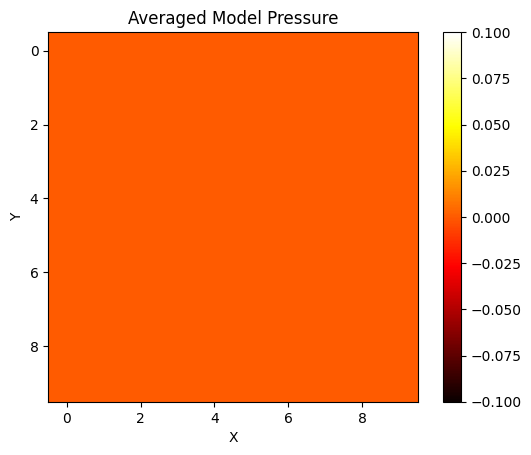

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the reservoir dimensions and grid block size
nx, ny, nz = 10, 10, 10
dx, dy, dz = 5, 5, 5

# Define the fluid types
fluids = ["oil", "gas", "water"]

# Define the petrophysical and fluid properties for each grid block
grid_properties = np.zeros((nx, ny, nz, len(fluids)))

# Set the initial conditions of pressure, saturations, temperatures, and equilibrium
initial_conditions = np.zeros((nx, ny, nz, len(fluids)))

# Define the boundary conditions
boundary_conditions = np.zeros((nx, ny, nz, len(fluids)))

# Define the producing well at the center of the reservoir
producing_well = np.array([nx // 2, ny // 2, nz // 2])

# Simulation time
simulation_time = 100

# Implement the flow equations
def flow_equations(grid_properties, initial_conditions, boundary_conditions):
    # Calculate the fluid fluxes
    fluid_fluxes = np.zeros((nx, ny, nz, len(fluids)))

    # Calculate the pressure changes
    pressure_changes = np.zeros((nx, ny, nz))

    return fluid_fluxes, pressure_changes

# Implement the mass balance equation
def mass_balance_equation(grid_properties, initial_conditions, boundary_conditions, fluid_fluxes, pressure_changes):
    # Calculate the changes in fluid saturations
    saturation_changes = np.zeros((nx, ny, nz, len(fluids)))

    return saturation_changes

# Implement the phase equilibrium and flash equation
def phase_equilibrium_and_flash(grid_properties, initial_conditions, boundary_conditions, saturation_changes):
    # Calculate the new fluid properties
    new_fluid_properties = np.zeros((nx, ny, nz, len(fluids)))

    return new_fluid_properties

# Simulate the fluid flow
fluid_fluxes, pressure_changes = flow_equations(grid_properties, initial_conditions, boundary_conditions)
saturation_changes = mass_balance_equation(grid_properties, initial_conditions, boundary_conditions, fluid_fluxes, pressure_changes)
new_fluid_properties = phase_equilibrium_and_flash(grid_properties, initial_conditions, boundary_conditions, saturation_changes)

# Calculate the averaged model pressure
averaged_model_pressure = np.mean(new_fluid_properties[:, :, :, 0], axis=(2,))

# Plot the averaged model pressure as a 2D heatmap
plt.imshow(averaged_model_pressure, interpolation='nearest', cmap='hot')

# Set the axes labels
plt.xlabel('X')
plt.ylabel('Y')

# Set the title
plt.title('Averaged Model Pressure')

plt.colorbar()  # Add a colorbar to the plot

plt.show()


Enter the production rate: 500


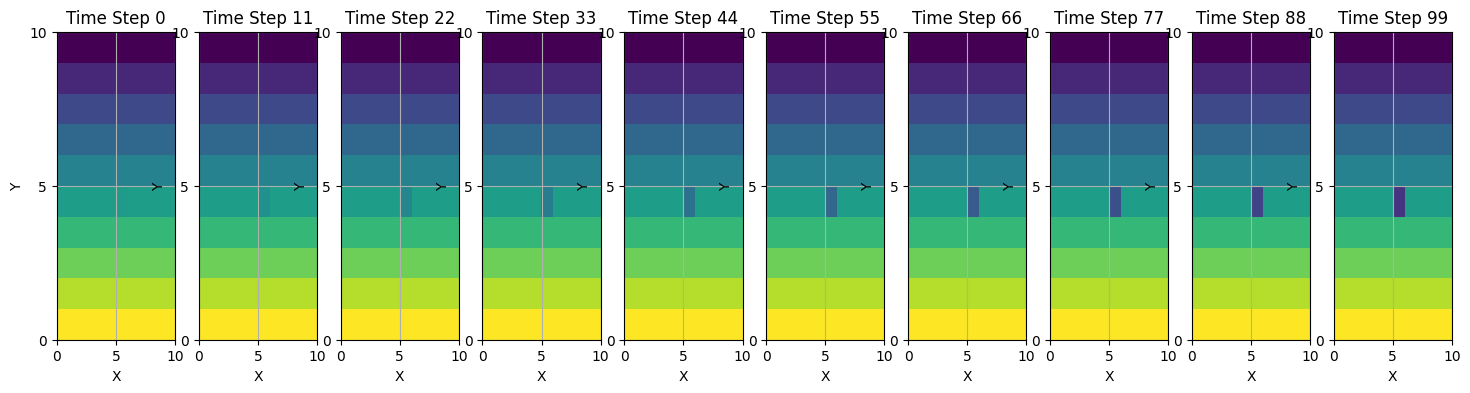

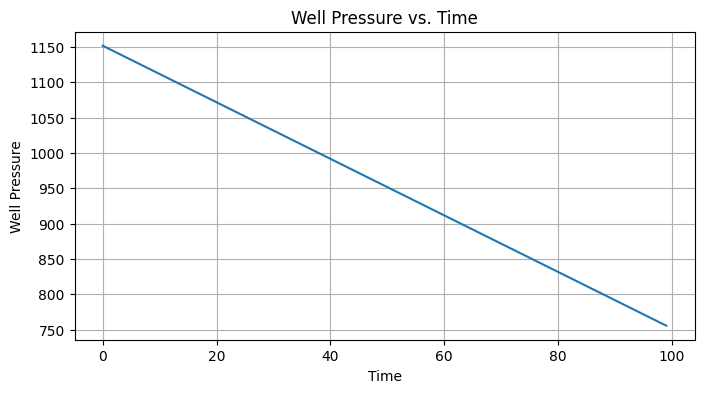

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the reservoir dimensions and grid block size
nx, ny, nz = 10, 10, 10
dx, dy, dz = 5, 5, 5

# Define the fluid types
fluids = ["oil", "gas", "water"]

# Define the petrophysical properties for each grid block
porosity = np.random.uniform(0.1, 0.3, size=(nx, ny, nz))
permeability = np.random.uniform(1e-12, 1e-10, size=(nx, ny, nz))

# Set the initial conditions of pressure, saturations, temperatures, and equilibrium
initial_pressure = np.linspace(1000, 2000, nz)
initial_conditions = np.zeros((nx, ny, nz, len(fluids)))
initial_conditions[:, :, :, 0] = initial_pressure[:, np.newaxis, np.newaxis]
initial_conditions[:, :, :, 1] = 1 - initial_conditions[:, :, :, 0] / 2000  # Initial gas saturation
initial_conditions[:, :, :, 2] = 0  # Initial water saturation

# Define the boundary conditions
boundary_conditions = np.zeros((nx, ny, nz, len(fluids)))

# Define the producing well at the center of the reservoir
producing_well = np.array([nx // 2, ny // 2, nz // 2])

# Define relative permeability curves for oil and gas
kr_oil = lambda S: S**2
kr_gas = lambda S: (1 - S)**2

# Simulation time
simulation_time = 100

# Initialize production rate (asked as input)
production_rate = float(input("Enter the production rate: "))

# Initialize lists to store pressure at the well and time
well_pressure = []
time = []

# Implement Darcy's law with relative permeabilities
def darcys_law(grid_properties, initial_conditions, boundary_conditions, permeability, relative_permeabilities):
    fluid_fluxes = np.zeros((nx, ny, nz, len(fluids)))

    for i in range(1, len(fluids)):  # Start from index 1 (oil) to avoid water
        kr = relative_permeabilities[i - 1](initial_conditions[:, :, :, i])
        fluid_fluxes[:, :, :, i - 1] = -kr * permeability * (initial_conditions[:, :, :, 0] - boundary_conditions[:, :, :, 0])

    return fluid_fluxes

# Implement the flow equations with saturation changes
def flow_equations(grid_properties, initial_conditions, boundary_conditions, permeability, relative_permeabilities):
    fluid_fluxes = darcys_law(grid_properties, initial_conditions, boundary_conditions, permeability, relative_permeabilities)
    pressure_changes = np.zeros((nx, ny, nz))

    return fluid_fluxes, pressure_changes

# Implement the mass balance equation with saturation changes
def mass_balance_equation(grid_properties, initial_conditions, boundary_conditions, fluid_fluxes, pressure_changes):
    saturation_changes = np.zeros((nx, ny, nz, len(fluids)))

    for i in range(1, len(fluids)):  # Start from index 1 (oil) to avoid water
        saturation_changes[:, :, :, i] = -(fluid_fluxes[:, :, :, i - 1] / (porosity * dx * dy * dz))

    return saturation_changes

# Implement the phase equilibrium and flash equation (simplified)
def phase_equilibrium_and_flash(grid_properties, initial_conditions, boundary_conditions, saturation_changes):
    new_fluid_properties = np.copy(initial_conditions)

    for i in range(1, len(fluids)):  # Start from index 1 (oil) to avoid water
        new_fluid_properties[:, :, :, i] += saturation_changes[:, :, :, i]

    return new_fluid_properties

# Number of time steps for heatmaps
num_heatmaps = 10

# Time steps at which to create heatmaps
heatmap_time_steps = np.linspace(0, simulation_time - 1, num_heatmaps, dtype=int)

# Lists to store pressure fields at different time steps
pressure_fields = []

# Simulate the fluid flow and record pressure fields at selected time steps
for t in range(simulation_time):
    # Calculate incremental pressure change due to production within the time step
    pressure_change = -(production_rate / (dx * dy * dz))

    # Update the pressure at the wellbore due to production
    initial_conditions[producing_well[0], producing_well[1], producing_well[2], 0] += pressure_change

    fluid_fluxes, pressure_changes = flow_equations(grid_properties, initial_conditions, boundary_conditions, permeability, [kr_oil, kr_gas])
    saturation_changes = mass_balance_equation(grid_properties, initial_conditions, boundary_conditions, fluid_fluxes, pressure_changes)
    new_fluid_properties = phase_equilibrium_and_flash(grid_properties, initial_conditions, boundary_conditions, saturation_changes)

    if t in heatmap_time_steps:
        pressure_fields.append(new_fluid_properties[:, :, producing_well[2], 0].copy())

    # Update initial conditions for the next time step
    initial_conditions = new_fluid_properties

# Plot pressure fields at selected time steps
fig, axs = plt.subplots(1, len(heatmap_time_steps), figsize=(18, 4))

for i, t in enumerate(heatmap_time_steps):
    axs[i].imshow(pressure_fields[i], cmap='viridis', extent=[0, nx, 0, ny], aspect='auto')
    axs[i].set_title(f'Time Step {t}')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_xticks(np.arange(0, nx+1, nx//2))
    axs[i].set_yticks(np.arange(0, ny+1, ny//2))
    axs[i].grid(True)

# Simulate the fluid flow and record well pressure over time
for t in range(simulation_time):
    # Calculate incremental pressure change due to production within the time step
    pressure_change = -(production_rate / (dx * dy * dz))

    # Update the pressure at the wellbore due to production
    initial_conditions[producing_well[0], producing_well[1], producing_well[2], 0] += pressure_change

    fluid_fluxes, pressure_changes = flow_equations(grid_properties, initial_conditions, boundary_conditions, permeability, [kr_oil, kr_gas])
    saturation_changes = mass_balance_equation(grid_properties, initial_conditions, boundary_conditions, fluid_fluxes, pressure_changes)
    new_fluid_properties = phase_equilibrium_and_flash(grid_properties, initial_conditions, boundary_conditions, saturation_changes)

    # Calculate and store pressure at the well
    well_pressure.append(initial_conditions[producing_well[0], producing_well[1], producing_well[2], 0])
    time.append(t)

# Plot fluid pressure at the well against time
plt.figure(figsize=(8, 4))
plt.plot(time, well_pressure)
plt.xlabel('Time')
plt.ylabel('Well Pressure')
plt.title('Well Pressure vs. Time')
plt.grid(True)
plt.show()
